In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# create dataset for best picture

In [2]:
oscar_df = pd.read_csv("data/the_oscar_award.csv")
oscar_df = oscar_df[oscar_df['year_ceremony'] >= 1937]
oscar_df['category'] = oscar_df['category'].str.lower() 
bp_mask = oscar_df['category'].str.contains('best|outstanding (motion)? picture')

C:\Users\Nick\AppData\Local\Temp\ipykernel_11700\3112563163.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  bp_mask = oscar_df['category'].str.contains('best|outstanding (motion)? picture')


## Feature Engineering
### Add Nominations and win count

In [3]:
#create all masks
actor_mask = oscar_df['category'].str.contains('actor( in a leading role)?$')
actress_mask = oscar_df['category'].str.contains('actress( in a leading role)?$')
director_mask = oscar_df['category'].str.contains('directing')
writer_mask = oscar_df['category'].str.contains('writing.*screenplay')
sup_actor_mask = oscar_df['category'].str.contains('actor in a supporting role')
sup_actress_mask = oscar_df['category'].str.contains('actress in a supporting role')

mask_dct = {
    'actor': actor_mask,
    'actress': actress_mask,
    'director': director_mask,
    'writer': writer_mask,
    'sup_actor': sup_actor_mask,
    'sup_actress': sup_actress_mask,
    'best_picture': bp_mask,
}

for k,v in mask_dct.items():
    oscar_df['category'] = np.where(v,k,oscar_df['category'])



big5_mask = actor_mask | actress_mask | bp_mask | director_mask | writer_mask
atl_mask = big5_mask | sup_actor_mask | sup_actress_mask

C:\Users\Nick\AppData\Local\Temp\ipykernel_11700\2362575656.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  actor_mask = oscar_df['category'].str.contains('actor( in a leading role)?$')
C:\Users\Nick\AppData\Local\Temp\ipykernel_11700\2362575656.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  actress_mask = oscar_df['category'].str.contains('actress( in a leading role)?$')


In [4]:
noms = oscar_df.groupby(['year_film', 'film']).size().rename('noms')
wins = oscar_df[oscar_df['winner']==True & ~bp_mask].groupby(['year_film', 'film'])['category'].nunique().rename('wins')

big5_noms = oscar_df[big5_mask].groupby(['year_film', 'film'])['category'].nunique().rename('big5_noms')
big5_wins = oscar_df[~bp_mask & big5_mask & oscar_df['winner']==True].groupby(['year_film', 'film'])['category'].nunique().rename('big5_wins')

atl_noms = oscar_df[atl_mask].groupby(['year_film', 'film'])['category'].nunique().rename('atl_noms')
atl_wins = oscar_df[~bp_mask & atl_mask & oscar_df['winner']==True].groupby(['year_film', 'film'])['category'].nunique().rename('atl_wins')

for ser in (noms,wins,big5_noms,big5_wins,atl_noms,atl_wins):
    oscar_df = pd.merge(oscar_df,ser,left_on=['year_film', 'film'],right_index=True,how='left')

oscar_df[['wins','big5_wins','atl_wins']] = oscar_df[['wins','big5_wins','atl_wins']].fillna(0)


In [5]:
noms_df = (~oscar_df[atl_mask].astype({'winner':int}).pivot_table(index=['year_ceremony','film'],columns='category',values='winner').isna())
wins_df = (~oscar_df[atl_mask&(oscar_df['winner'])].astype({'winner':int}).pivot_table(index=['year_ceremony','film'],columns='category',values='wins').isna())

#remove best_film from both datasets
noms_df = noms_df.drop('best_picture',axis=1)
wins_df = wins_df.drop('best_picture',axis=1)

In [6]:
oscar_df = pd.merge(oscar_df,noms_df,left_on=['year_ceremony','film'],right_index=True,how='left',suffixes=('','_noms'))
oscar_df = pd.merge(oscar_df,wins_df,left_on=['year_ceremony','film'],right_index=True,how='left',suffixes=('_noms','_wins'))


In [7]:
oscar_df.isna().sum()
oscar_df[['atl_noms','big5_noms']] = oscar_df[['atl_noms','big5_noms']].fillna(0)
noms_wins_cols = oscar_df.columns[oscar_df.columns.str.contains('_wins|_noms$')]
oscar_df[noms_wins_cols] = oscar_df[noms_wins_cols].fillna(False)

## Filter Best Picture, remove data leakage, split data

In [8]:
model_df = oscar_df[oscar_df['category']=='best_picture'].set_index(['year_ceremony','film']).drop('category',axis=1)
model_df.drop(['year_film','ceremony','name'],axis=1,inplace=True)
model_df = model_df.astype(int)


#remove data leakage
model_df[model_df['winner']==1][['wins','big5_wins','atl_wins']] = model_df[model_df['winner']==1][['wins','big5_wins','atl_wins']]

C:\Users\Nick\AppData\Local\Temp\ipykernel_11700\4136675931.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[model_df['winner']==1][['wins','big5_wins','atl_wins']] = model_df[model_df['winner']==1][['wins','big5_wins','atl_wins']]


In [32]:
test_mask = model_df.index.get_level_values(0) >= 2007

train_df = model_df[~test_mask]
test_df = model_df[test_mask]

# Train Model

In [33]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
model = GaussianNB()
model.fit(train_df.drop('winner',axis=1),train_df['winner'])

test_df['predict'] = model.predict_proba(test_df.drop('winner',axis=1))[:,1]

C:\Users\Nick\AppData\Local\Temp\ipykernel_11700\902639753.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predict'] = model.predict_proba(test_df.drop('winner',axis=1))[:,1]


In [34]:
predictions = test_df.groupby('year_ceremony')['predict'].idxmax()
actual = test_df.groupby('year_ceremony')['winner'].idxmax()

In [35]:
(predictions == actual).sum()/len(predictions)

0.6470588235294118

In [36]:
pd.concat([predictions,actual],axis = 1)

,predict,winner
year_ceremony,,
2007,"(2007, The Departed)","(2007, The Departed)"
2008,"(2008, No Country for Old Men)","(2008, No Country for Old Men)"
2009,"(2009, Slumdog Millionaire)","(2009, Slumdog Millionaire)"
2010,"(2010, The Hurt Locker)","(2010, The Hurt Locker)"
2011,"(2011, The King's Speech)","(2011, The King's Speech)"
2012,"(2012, The Artist)","(2012, The Artist)"
2013,"(2013, Life of Pi)","(2013, Argo)"
2014,"(2014, Gravity)","(2014, 12 Years a Slave)"
2015,"(2015, Birdman or (The Unexpected Virtue of Ig...","(2015, Birdman or (The Unexpected Virtue of Ig..."


## Create Probability Distribution for each variable
By training a naive bayes model, the algorithm creates the probability distributions it believes to be the most accurate to predict the outcome. ie how likely will a movie win an oscar if it gets 0 other nominations, vs 1, 2 etc.

These can be useful to plot and then interpret

In [92]:
#first get the parameters and put them in a dataframe

#[1] is selected to reflect the distributions for predicting winning the award
var_df = pd.DataFrame({'theta':model.theta_[1],'var':model.var_[1]},index=model.feature_names_in_)

#add min, max for every variable. This will be needed for plots later
mm_df = model_df.describe().loc[['min','max'],var_df.index].T
var_df = pd.merge(var_df,mm_df,left_index=True,right_index=True)
var_df

,theta,var,min,max
noms,9.538462,4.740828,1.0,14.0
wins,4.723077,4.446391,1.0,10.0
big5_noms,3.923077,0.440237,1.0,5.0
big5_wins,1.969231,0.829822,0.0,4.0
atl_noms,4.923077,1.117160,1.0,7.0
atl_wins,2.338462,1.023905,0.0,5.0
actor_noms,0.692308,0.213018,0.0,1.0
actress_noms,0.307692,0.213018,0.0,1.0
director_noms,0.984615,0.015148,0.0,1.0
sup_actor_noms,0.630769,0.232899,0.0,1.0


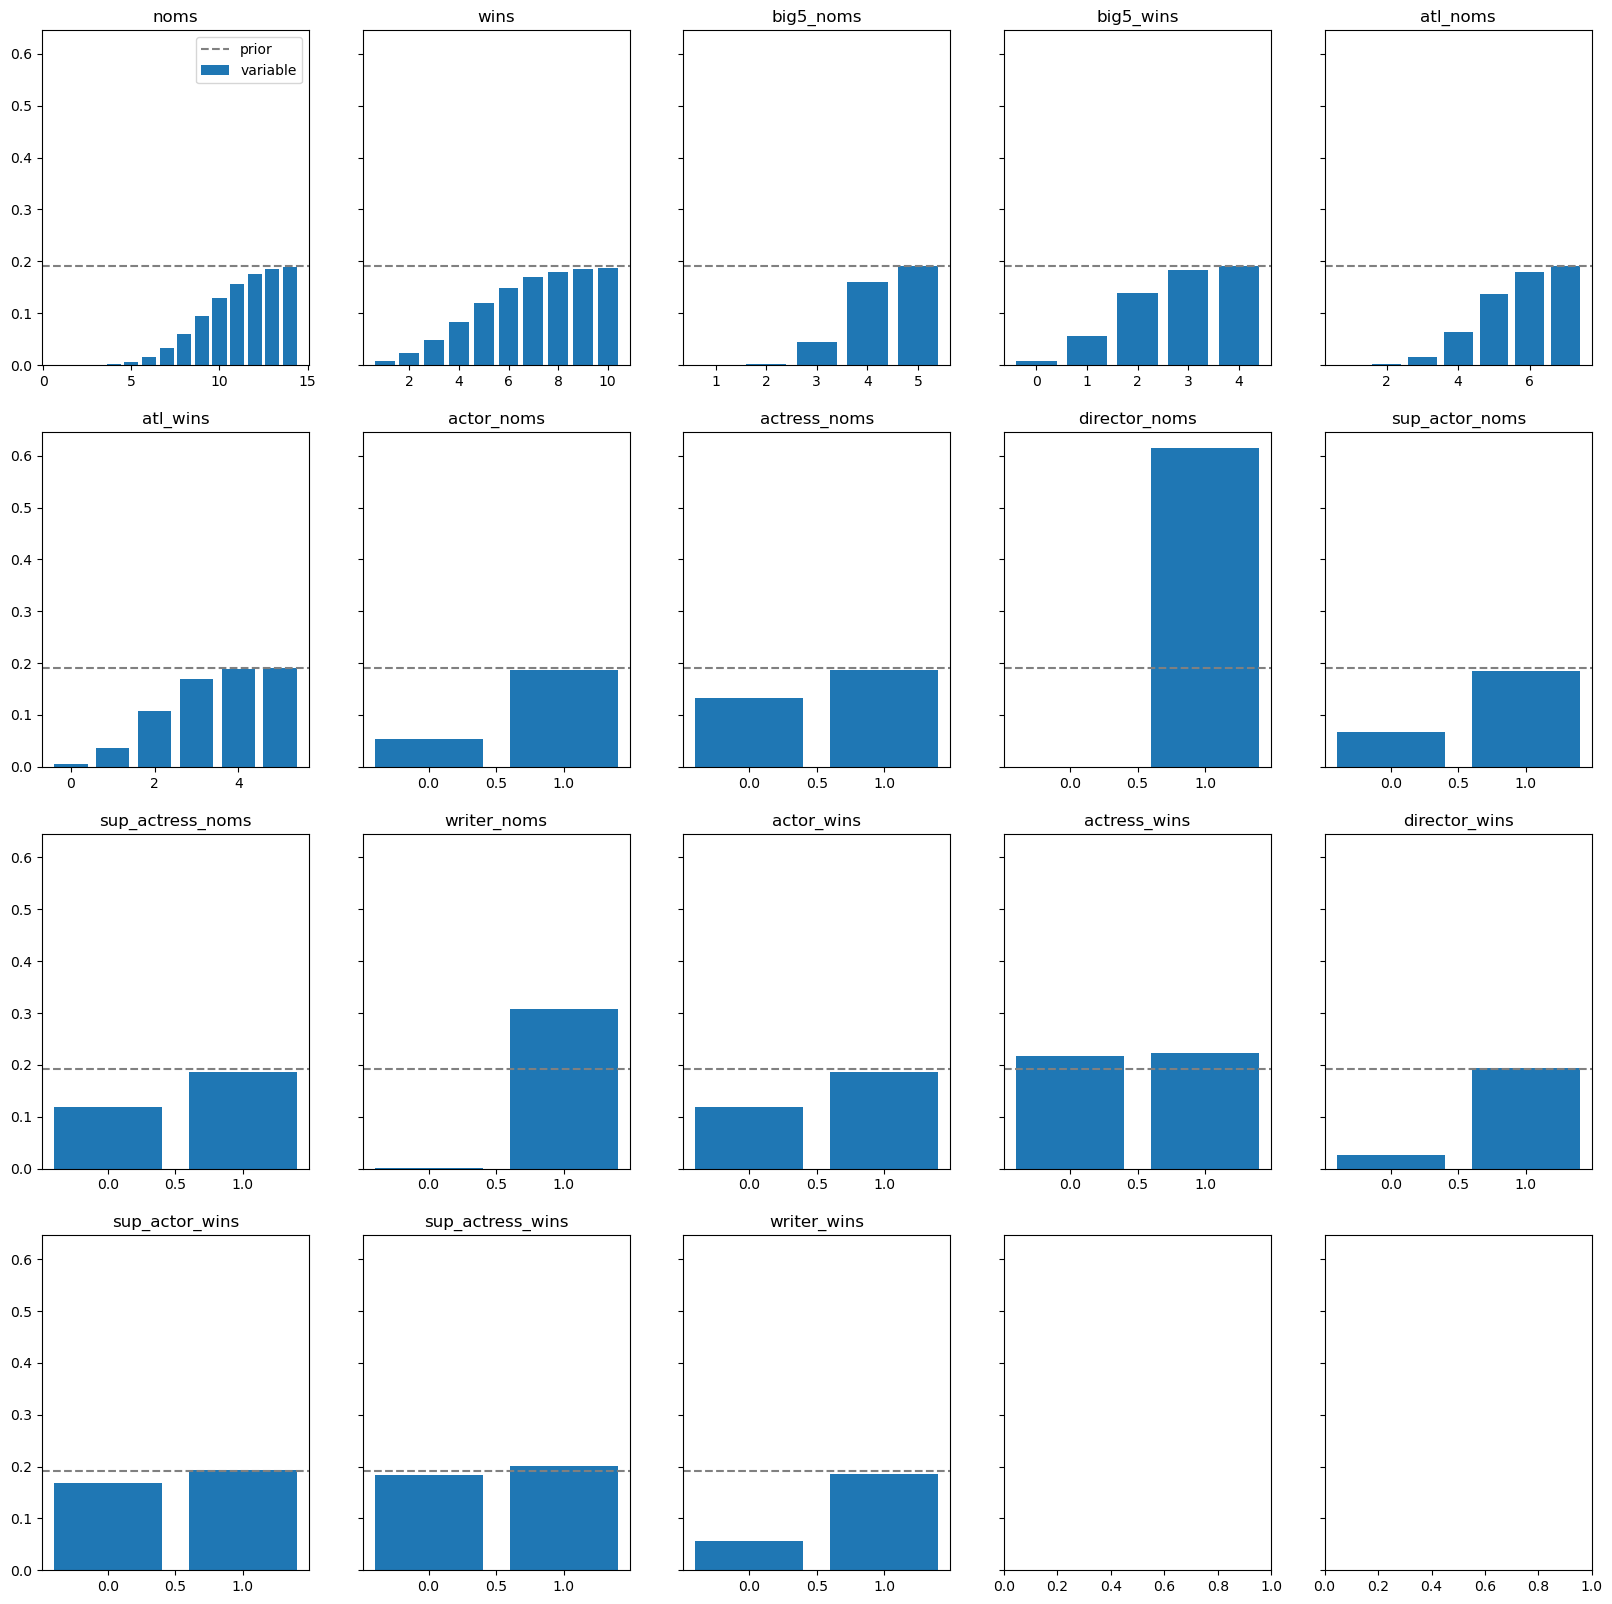

In [140]:
def calc_prob(prior,theta,var,x):
    #calculate the probability of y given the parameters

    
    log_prior = np.log(prior)
    n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * var))
    n_ij -= 0.5 * ((x - theta) ** 2) / (var)
    p = np.exp(log_prior + n_ij)

    return p



prior = model.class_prior_[1]

#plot the distributions in a grid
fig, axes = plt.subplots(4,int(np.ceil(var_df.shape[0]/4)),figsize=(20,20),sharey=True)
first= True
for (ax, (var_name,ser)) in zip(axes.flatten(),var_df.iterrows()):
    
    #data is discrete so only plot integers including the max value
    x = np.arange(ser['min'],ser['max']+1)
    
    y = calc_prob(prior,ser['theta'],ser['var'],x)
    ax.bar(x,y.cumsum(),label='variable')
    ax.axhline(prior,linestyle='--',color='grey',label='prior')
    ax.set_title(var_name)
    if first:
        first = False
        ax.legend()

plt.show()

## Observations
* Director nominations have the greatest impact improving the odds of winning Best Picture Oscar
* Actor nominations and wins have a greater influence at predicting a winner than actress. Quite shockingly, a film winning best actress does not seem to impact the likelihood of winning a Best Picture at all.
* Not having a nomination for best screenplay lowers the chance at winning the oscar

In [145]:
#normalised count of winners vs. non winners
train_df['winner'].value_counts(normalize=True)

0    0.808824
1    0.191176
Name: winner, dtype: float64

In [160]:
#normalised count of winners vs. non winners where film had 0 director nominations

train_df[(train_df['director_noms']==0)]['winner'].value_counts(normalize=True)

0    0.990476
1    0.009524
Name: winner, dtype: float64

In [158]:
#normalised count of winners vs. non winners where film won best actress

train_df[(train_df['actress_wins']==1)]['winner'].value_counts(normalize=True)

0    0.809524
1    0.190476
Name: winner, dtype: float64